# Bitcoin Price Prediction
Group 17: Zijun Fu (zf2342), Xiaoyu Fang (xf2282), Ruoshi Zhang (rz2699), and Ruyue Zhang (rz2729)

# Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import requests
import time
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

## Yahoo Finance Dataset
You can access Yahoo Finance by visiting the link below:
> https://finance.yahoo.com/quote/BTC-USD

Here we fetches daily OHLCV (Open, High, Low, Close, Volume) data for BTC/USD from the CryptoCompare “histoday” API, covering the period **2014-01-01** to **2023-12-31**.


In [ ]:
def fetch_btc_histoday(to_ts: int, limit: int = 2000):
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    params = {
        "fsym": "BTC",            # symbol: Bitcoin
        "tsym": "USD",            # quote currency: USD
        "limit": limit - 1,       # API’s limit includes the current day
        "toTs": to_ts             # end timestamp
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()["Data"]["Data"]
    df_d = pd.DataFrame(data)
    df_d = df_d.rename(columns={
        "time": "Date",
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Price",
        "volumefrom": "Vol."
    })
    df_d["Date"] = pd.to_datetime(df_d["Date"], unit="s").dt.date
    return df_d[["Date", "Open", "High", "Low", "Price", "Vol."]]

start = pd.to_datetime("2014-01-01").date()
end   = pd.to_datetime("2023-12-31").date()
end_ts = int(pd.Timestamp(end).timestamp())

df1 = fetch_btc_histoday(to_ts=end_ts, limit=2000)
prev_to_ts = int(pd.Timestamp(df1["Date"].min()).timestamp()) - 1
df2 = fetch_btc_histoday(to_ts=prev_to_ts, limit=2000)

df = pd.concat([df2, df1], ignore_index=True)
df = (
    df[df["Date"] >= start]
    .drop_duplicates(subset="Date")
    .sort_values("Date")
    .reset_index(drop=True)
)

df["Change %"] = df["Price"].pct_change() * 100
print(df.head(), "\n", df.tail())

df.to_csv("BTC_OHLCV_2014_2023_cryptocompare.csv", index=False)


         Date    Open     High     Low    Price      Vol.  Change %
0  2014-01-01  805.94   829.93  770.97   815.94  10757.23       NaN
1  2014-01-02  815.94   886.21  810.47   856.91  12811.63  5.021203
2  2014-01-03  856.91   888.23  839.44   884.26   9709.01  3.191700
3  2014-01-04  884.26   932.16  848.32   924.69  14239.01  4.572185
4  2014-01-05  924.69  1029.86  911.36  1014.74  21374.20  9.738399 
             Date      Open      High       Low     Price      Vol.  Change %
3647  2023-12-27  42517.32  43694.83  42121.77  43469.34  27420.29  2.239135
3648  2023-12-28  43469.34  43817.61  42283.91  42588.94  29112.04 -2.025336
3649  2023-12-29  42588.94  43134.59  41296.86  42073.59  34268.41 -1.210056
3650  2023-12-30  42073.59  42595.81  41529.95  42146.03  21511.57  0.172175
3651  2023-12-31  42146.03  42863.11  41970.37  42280.14  21509.24  0.318203


In [ ]:
all_data = []

for year in range(2014, 2024):
    start_date = f"{year}-01-01"
    url = f"https://api.blockchain.info/charts/total-bitcoins?start={start_date}&timespan=365days&format=json"

    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        for point in data['values']:
            all_data.append({
                "Date": datetime.utcfromtimestamp(point['x']),
                "total_btc_mined": point['y']
            })
    else:
        print(f"Failed to fetch data for {year}")

df1 = pd.DataFrame(all_data)
df1['Date'] = df1['Date'].dt.date
btc_daily = df1.groupby('Date').last().reset_index()[['Date', 'total_btc_mined']]

Approximately every four years, the Bitcoin mining reward is halved.

Past halving date:


*   2012 Halving: November 28, 2012
*   2016 Halving: July 9, 2016
*   2020 Halving: May 11, 2020
*   2024 Halving: April 19, 2024

https://calendar.bitbo.io/halving-dates/






In [ ]:
btc_daily['Date'] = pd.to_datetime(btc_daily['Date'])
btc_daily['reward'] = 6.25  # default

btc_daily.loc[btc_daily['Date'] < '2020-05-11', 'reward'] = 12.5
btc_daily.loc[btc_daily['Date'] < '2016-07-09', 'reward'] = 25

$SF = \frac{Stock}{Flow} = \frac{Stock}{144 * 365*Reward}$


In [ ]:
btc_daily['sf_ratio'] = btc_daily['total_btc_mined'] / (btc_daily['reward'] * 365 * 144)

In [ ]:
df['Date']       = pd.to_datetime(df['Date'])
btc_daily['Date'] = pd.to_datetime(btc_daily['Date'])

df = df.merge(btc_daily, on='Date', how='inner')
df.tail()

,Date,Open,High,Low,Price,Vol.,Change %,total_btc_mined,reward,sf_ratio
3645,2023-12-27,42517.32,43694.83,42121.77,43469.34,27420.29,2.239135,19582437.5,6.25,59.611682
3646,2023-12-28,43469.34,43817.61,42283.91,42588.94,29112.04,-2.025336,19583337.5,6.25,59.614422
3647,2023-12-29,42588.94,43134.59,41296.86,42073.59,34268.41,-1.210056,19584237.5,6.25,59.617161
3648,2023-12-30,42073.59,42595.81,41529.95,42146.03,21511.57,0.172175,19585137.5,6.25,59.619901
3649,2023-12-31,42146.03,42863.11,41970.37,42280.14,21509.24,0.318203,19586037.5,6.25,59.622641


# Method 1 - Linear Regression
* Least Squares Regression
* Polynomial Regression




## Model 1 - Least Squares Regression
A linear least squares model to assess the influence of the Stock-to-Flow (SF) ratio in a regression context.

To calculated the SF ratio
*   Create a new dataframe named `btc_daily` including the total number of mined bitcoin. The data is from *blockchain.com*.
*   Furthermore, add a new column to `btc_daily` indicating the corresponding bitcoins rewarded to miners.




In [ ]:
# Log-transform
X_log = np.log(df[['sf_ratio']])
X_log.columns = ['ln(SF)']
y_log = np.log(df['Price'])
y_log.columns = ['ln(Price)']

# Add intercept
X_const = sm.add_constant(X_log)

# Fit the model
model = sm.OLS(y_log, X_const).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 2.272e+04
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:25:10   Log-Likelihood:                -3697.3
No. Observations:                3650   AIC:                             7399.
Df Residuals:                    3648   BIC:                             7411.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.057      0.057      0.9

The linear model suggest that:



*   $ln(Price) = \beta_0 + \beta_1 * ln(SF)$



where $a$ and $b$ are estimates of the slope and the intercept respectively.

Based on the results of OLS, the intercepts $\beta_0  = 0.0035$ and the slope $\beta_1 = 2.5314$.

Furethermore, after testing $H_0$: $\beta_1 = 0$, the extreme small p-value indicates that there is very strong evidence that Stock-to-Flow ratio significantly predicts bitcoin price. A 1% increase in SF is associated with a 2.53% increase in price. The magnitude suggests a strong elasticity of price to scarcity.



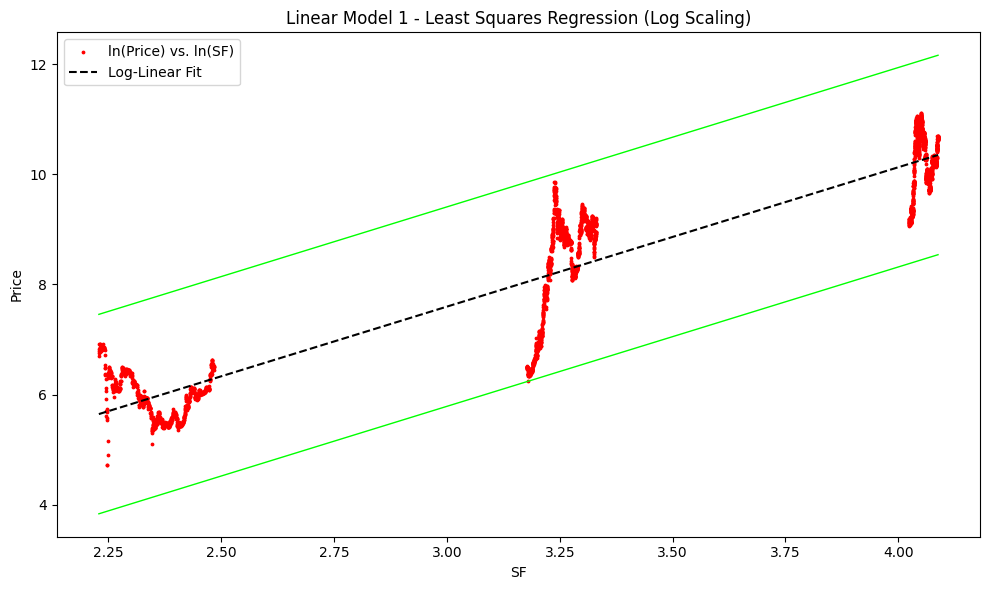

In [ ]:
# Plot Bitcoin Price vs. Stock-to-Flow Ratio
y_pred = model.predict(X_const)

# Calculate bounds for least containing stripe
residuals = y_log - y_pred
margin = np.max(np.abs(residuals))
upper_bound = y_pred + margin
lower_bound = y_pred - margin

plt.figure(figsize=(10, 6))
plt.scatter(X_log, y_log, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X_log, y_pred, 'k--', label='Log-Linear Fit')
plt.plot(X_log, upper_bound, 'lime', linewidth=1)
plt.plot(X_log, lower_bound, 'lime', linewidth=1)

plt.xlabel('SF')
plt.ylabel('Price')
plt.title(f'Linear Model 1 - Least Squares Regression (Log Scaling)')
plt.legend()
plt.tight_layout()
plt.show()

### N-Fold Cross Validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

rmse_list = []
r2_list = []
coefs = []

for train_idx, test_idx in kf.split(X_log):
  X_train, X_test = X_log.iloc[train_idx], X_log.iloc[test_idx]
  y_train, y_test = y_log.iloc[train_idx], y_log.iloc[test_idx]

  model_CV = LinearRegression()
  model_CV.fit(X_train, y_train)

  y_pred = model_CV.predict(X_test)

  r2_list.append(r2_score(y_test, y_pred))
  rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
  coefs.append((model_CV.intercept_, model_CV.coef_[0]))

cv_results = pd.DataFrame({
    'Fold': list(range(1, 6)),
    'R_squared': r2_list,
    'RMSE': rmse_list,
    'Intercept': [c[0] for c in coefs],
    'Slope': [c[1] for c in coefs]
})

r2_mean = cv_results['R_squared'].mean()
rmse_mean = cv_results['RMSE'].mean()

print("Linear Model 1 - Least Squares Model Prediction Performance:")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

Linear Model 1 - Least Squares Model Prediction Performance:
R^2 Mean = 0.8613
RMSE Mean = 0.6666


## Model 2 - Polynomial Regression

Linear Model 2 - Polynomial Linear Regression Prediction Performance：
R^2 Mean = 0.8615
RMSE Mean = 0.6662


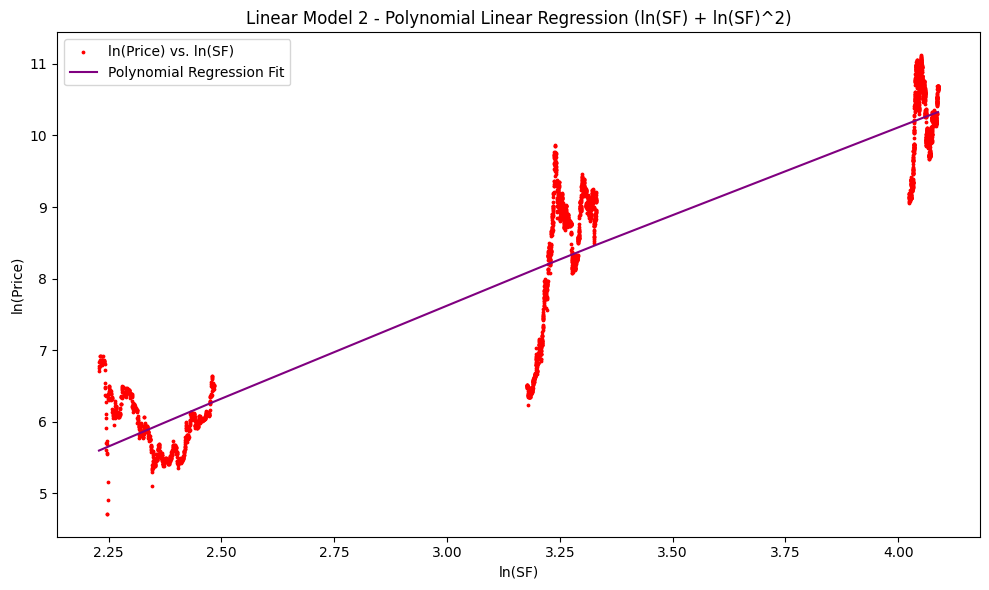

ln(SF): 3.0836
ln(SF)^2: -0.0855
Intercept: -0.8499


In [ ]:
# Prepare polynomial features: ln(SF), ln(SF)^2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_log)  # shape: (n_samples, 2) = [ln(SF), ln(SF)^2]
y = y_log.values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

# Initialize linear regression model
model2 = LinearRegression()

# Cross-validation
for train_idx, test_idx in kf.split(X_poly):
    X_train, X_test = X_poly[train_idx], X_poly[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model2.fit(X_train, y_train)
    y_pred = model2.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Average performance
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Linear Model 2 - Polynomial Linear Regression Prediction Performance：")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit the full model for visualization
model2.fit(X_poly, y)
y_pred_poly = model2.predict(X_poly)

# Sort data for smooth plotting
sorted_idx = X_log['ln(SF)'].argsort()
x_plot = X_log.values[sorted_idx]
y_true = y[sorted_idx]
y_pred_plot = y_pred_poly[sorted_idx]

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_log, y_log, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(x_plot, y_pred_plot, color='purple', label='Polynomial Regression Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Linear Model 2 - Polynomial Linear Regression (ln(SF) + ln(SF)^2)')
plt.legend()
plt.tight_layout()
plt.show()

# Summary
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_log)

feature_names = poly.get_feature_names_out(X_log.columns)
for name, coef in zip(feature_names, model2.coef_):
    print(f"{name}: {coef:.4f}")
print(f"Intercept: {model2.intercept_:.4f}")

# Method 2 - Non-Linear Model
- SVR (RBF Kernel)
- Gradient Boosting
- Random Forest

## Model 1 - SVR (RBF Kernel)

In [ ]:
# Use the same log-transformed variables from Model 1
X = X_log.values
y = y_log.values

# Create a pipeline with scaler and SVR (scaling improves performance)
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

# Define grid search parameter space
param_grid = {
    'svr__C': [1, 10, 100, 1000],
    'svr__gamma': ['scale', 0.01, 0.1, 1],
    'svr__epsilon': [0.01, 0.05, 0.1, 0.5, 0.8, 1]
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


Best Parameters: {'svr__C': 1, 'svr__epsilon': 0.8, 'svr__gamma': 0.01}


Non-Linear Model 1 - SVR(RBF) Prediction Performance
R^2 Mean = 0.8513
RMSE Mean = 0.6902


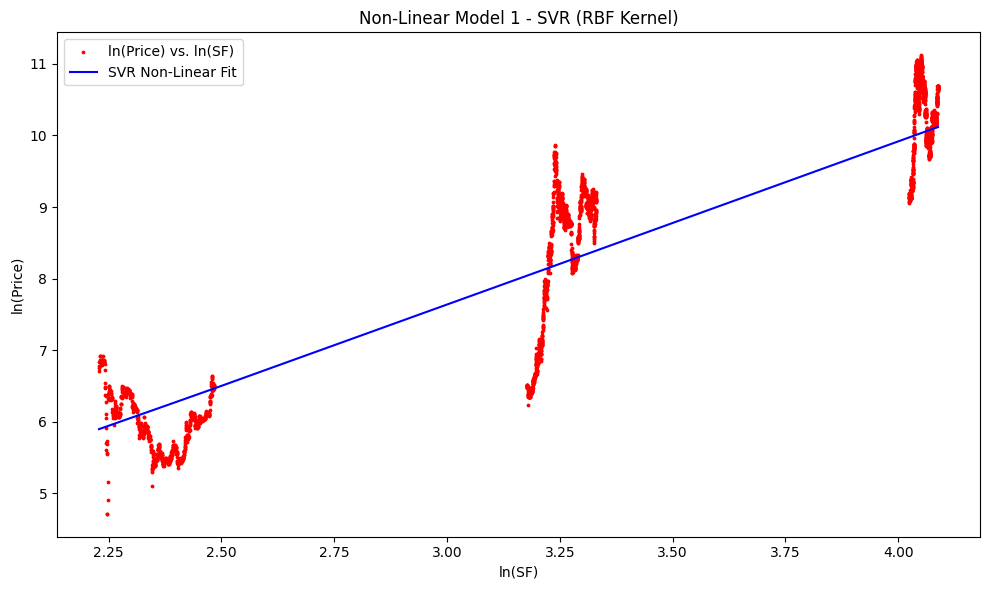

In [ ]:
# Non-Linear Model 1 - SVR with RBF Kernel
# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
r2_list = []

# Initialize the SVR model (RBF kernel with default tuned parameters)
model3 = SVR(kernel='rbf', C=1, gamma=0.01, epsilon=0.8)

# Perform cross-validation
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model3.fit(X_train, y_train)
    y_pred = model3.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Report average performance across all folds
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Non-Linear Model 1 - SVR(RBF) Prediction Performance")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit SVR model on the entire dataset for visualization
model3.fit(X, y)
y_pred_svr = model3.predict(X)

# Visualize the SVR non-linear fitting curve
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X, y_pred_svr, color='blue', label='SVR Non-Linear Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Non-Linear Model 1 - SVR (RBF Kernel)')
plt.legend()
plt.tight_layout()
plt.show()


## Model 2 - Gradient Boosting

In [ ]:
# Prepare data
X = X_log.values
y = y_log.values

# Define model and parameter grid
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 30, 50, 100, 200],
    'max_depth': [1, 2, 3, 4, None],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(gbr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Extract best parameters
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best Parameters Found:")
print(best_params)
print(f"Best RMSE (5-fold CV): {best_rmse:.4f}")


Fitting 5 folds for each of 75 candidates, totalling 375 fits


Best Parameters Found:
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100}
Best RMSE (5-fold CV): 0.7938


Non-Linear Model 2 - Gradient Boosting Regression Performance:
R^2 Mean = 0.9677
RMSE Mean = 0.3215


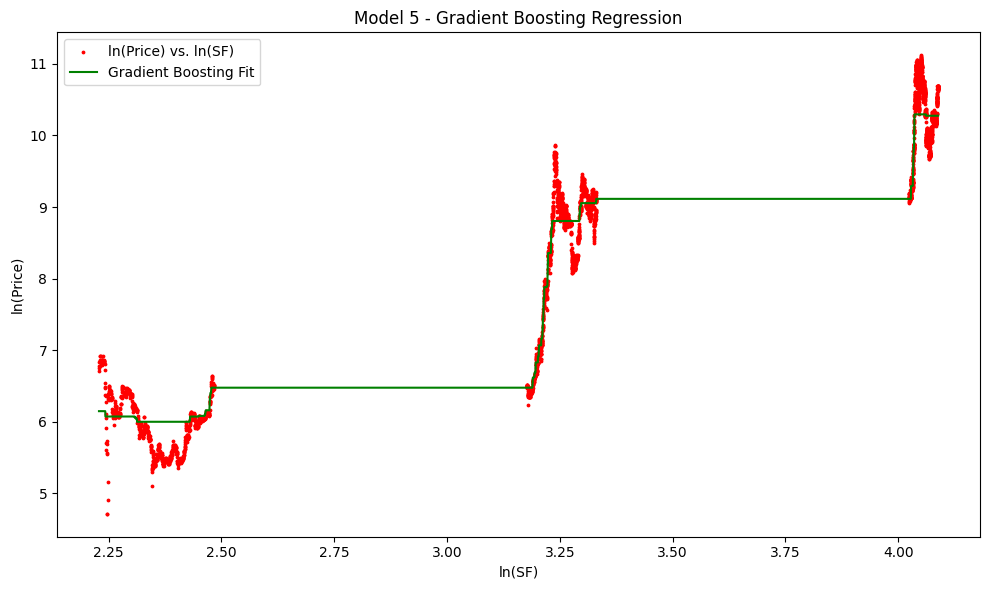

In [ ]:
# Use ln(SF) as input, ln(Price) as output
X = X_log.values  # ln(SF)
y = y_log.values  # ln(Price)

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

# Initialize the Gradient Boosting Regressor
model5 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=1, random_state=42)

# Cross-validation loop
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model5.fit(X_train, y_train)
    y_pred = model5.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Report average performance
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Non-Linear Model 2 - Gradient Boosting Regression Performance:")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit full model on entire data for visualization
model5.fit(X, y)
y_pred_gb = model5.predict(X)

# Plot the fitting curve
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X, y_pred_gb, color='green', label='Gradient Boosting Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Model 5 - Gradient Boosting Regression')
plt.legend()
plt.tight_layout()
plt.show()


## Model 3 - Random Forest

In [ ]:
# Define RMSE scorer
def rmse_score(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))  # negative for GridSearchCV

rmse_scorer = make_scorer(rmse_score)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5, 7, None],
    'min_samples_leaf': [1, 3, 5, 10]
}

# Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring=rmse_scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X, y)

# Output best parameters and score
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print("Best Parameters for Random Forest:")
print(best_params)
print(f"Best RMSE (5-fold CV): {best_rmse:.4f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters for Random Forest:
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best RMSE (5-fold CV): 0.7324


Non-Linear Model 3 - Random Forest Regression Performance:
R^2 Mean = 0.8251
RMSE Mean = 0.7485


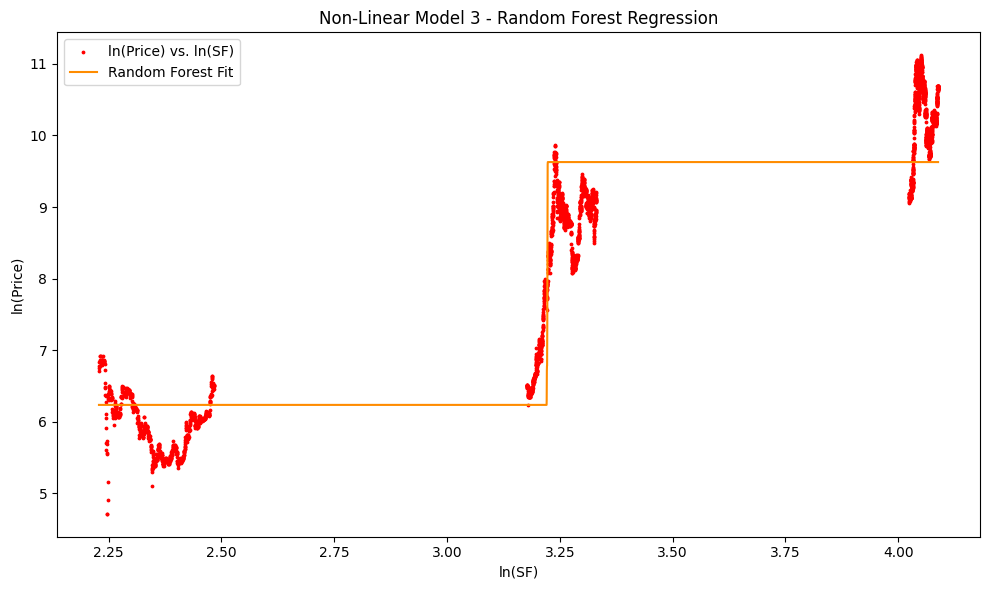

In [ ]:
# Feature and target
X = X_log.values  # ln(SF)
y = y_log.values  # ln(Price)

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

# Define the Random Forest model
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=1,            # Control overfitting
    random_state=42,
    min_samples_leaf=1      # More stable splits
)

# Cross-validation loop
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Report average metrics
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Non-Linear Model 3 - Random Forest Regression Performance:")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit full model for visualization
model_rf.fit(X, y)
y_pred_rf = model_rf.predict(X)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X, y_pred_rf, color='darkorange', label='Random Forest Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Non-Linear Model 3 - Random Forest Regression')
plt.legend()
plt.tight_layout()
plt.show()

# Method 3 - Deep Learning model
- LSTM
- transformer

For our deep learning approach, we trained two complementary sequence models to predict daily Bitcoin prices:

- **Bidirectional LSTM**  
  A two-layer, bidirectional Long Short-Term Memory network that leverages recent price momentum, volatility and on-chain signals (e.g. SF ratio, realized volatility, moving averages, RSI). Its gated memory cells allow rapid adaptation to abrupt market swings, yielding high fidelity one-day-ahead forecasts.

- **Transformer**  
  A lightweight time-series Transformer with multi-head self-attention and a small feed-forward head. By attending across the entire 60-day input window, it captures broader market regimes and trend structures, producing smoother forecasts that emphasize medium-term stability over high-frequency noise.

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Bidirectional, BatchNormalization,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df["Velocity"]   = df["Vol."] / df["sf_ratio"]    # on-chain flow/stock
df["MA7"]        = df["Price"].rolling(7).mean()
df["MA21"]       = df["Price"].rolling(21).mean()
df["MA_Cross"]   = df["MA7"] - df["MA21"]
delta            = df["Price"].diff().fillna(0)
gain             = delta.clip(lower=0)
loss             = -delta.clip(upper=0)
avg_gain         = gain.rolling(14).mean()
avg_loss         = loss.rolling(14).mean()
rs               = avg_gain / (avg_loss + 1e-6)
df["RSI14"]      = 100 - (100 / (1 + rs))
df["Vol_Mom3"]   = df["Vol."].pct_change(3).fillna(0)

df.dropna(inplace=True)

In [ ]:
features = [
  "sf_ratio", "Velocity",
  "MA7", "MA21", "MA_Cross",
  "RSI14", "Vol_Mom3"
]
target = "Price"


In [ ]:
# 1. Extract raw arrays
X_raw = df[features].values
y_raw = df[[target]].values  # shape (n,1)

# 2. Chronological 80/20 split
split = int(len(df) * 0.8)
X_tr_raw, X_te_raw = X_raw[:split], X_raw[split:]
y_tr_raw, y_te_raw = y_raw[:split], y_raw[split:]

# 3. Scale on training only
scaler_X = MinMaxScaler().fit(X_tr_raw)
scaler_y = MinMaxScaler().fit(y_tr_raw)

X_tr = scaler_X.transform(X_tr_raw)
X_te = scaler_X.transform(X_te_raw)
y_tr = scaler_y.transform(y_tr_raw).flatten()
y_te = scaler_y.transform(y_te_raw).flatten()

# 4. Build 60-day sliding windows
time_steps = 60
def make_seq(X, y=None):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        if y is not None:
            ys.append(y[i])
    return np.array(Xs), (np.array(ys) if y is not None else None)

X_train, y_train = make_seq(X_tr, y_tr)
X_test,  y_test  = make_seq(
    np.vstack([X_tr[-time_steps:], X_te]),
    np.concatenate([y_tr[-time_steps:], y_te])
)



In [ ]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Enabled memory growth on", gpus[0])
    except RuntimeError:
        print("GPU already initialized—skipping memory growth setup")

model_lstm = Sequential([
    LSTM(64, return_sequences=True, activation="tanh",
         input_shape=(time_steps, len(features))),
    Dropout(0.2),
    LSTM(32, activation="tanh"),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer="adam", loss="mae")

es = EarlyStopping("val_loss", patience=5, restore_best_weights=True)
model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=64,
    callbacks=[es],
    verbose=2
)

def build_transformer(seq_len, num_feats,
                      head_size=32, num_heads=2, ff_dim=64, dropout=0.1):
    inp = Input(shape=(seq_len, num_feats))
    # 1) Self-attention
    x = LayerNormalization()(inp)
    att = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(x, x)
    x = Dropout(dropout)(att) + inp
    # 2) Feed-forward
    y = LayerNormalization()(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(num_feats)(y)
    x = Dropout(dropout)(y) + x
    # 3) Pool & output
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    out = Dense(1)(x)
    return Model(inputs=inp, outputs=out)

model_tr = build_transformer(time_steps, len(features))
model_tr.compile(optimizer="adam", loss="mae")
model_tr.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, batch_size=64,
    callbacks=[es],
    verbose=2
)

GPU already initialized—skipping memory growth setup
Epoch 1/50


/home/fangxy/anaconda3/envs/codingass4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 - 3s - 67ms/step - loss: 0.0642 - val_loss: 0.0333
Epoch 2/50
45/45 - 1s - 23ms/step - loss: 0.0280 - val_loss: 0.0240
Epoch 3/50
45/45 - 1s - 20ms/step - loss: 0.0241 - val_loss: 0.0240
Epoch 4/50
45/45 - 1s - 20ms/step - loss: 0.0231 - val_loss: 0.0210
Epoch 5/50
45/45 - 1s - 24ms/step - loss: 0.0206 - val_loss: 0.0425
Epoch 6/50
45/45 - 1s - 24ms/step - loss: 0.0198 - val_loss: 0.0199
Epoch 7/50


45/45 - 1s - 24ms/step - loss: 0.0213 - val_loss: 0.0474
Epoch 8/50
45/45 - 1s - 22ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 9/50
45/45 - 1s - 24ms/step - loss: 0.0196 - val_loss: 0.0319
Epoch 10/50
45/45 - 1s - 22ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 11/50
45/45 - 1s - 23ms/step - loss: 0.0178 - val_loss: 0.0193
Epoch 12/50
45/45 - 1s - 23ms/step - loss: 0.0173 - val_loss: 0.0198
Epoch 13/50
45/45 - 1s - 21ms/step - loss: 0.0183 - val_loss: 0.0192
Epoch 14/50
45/45 - 1s - 30ms/step - loss: 0.0173 - val_loss: 0.0190
Epoch 15/50
45/45 - 1s - 23ms/step - loss: 0.0173 - val_loss: 0.0204
Epoch 16/50
45/45 - 1s - 22ms/step - loss: 0.0174 - val_loss: 0.0392
Epoch 17/50
45/45 - 1s - 24ms/step - loss: 0.0175 - val_loss: 0.0311
Epoch 18/50
45/45 - 1s - 23ms/step - loss: 0.0169 - val_loss: 0.0220
Epoch 19/50
45/45 - 1s - 29ms/step - loss: 0.0170 - val_loss: 0.0310
Epoch 1/50


2025-05-08 15:26:00.568181: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_select_fusion', 68 bytes spill stores, 72 bytes spill loads



45/45 - 11s - 245ms/step - loss: 0.2973 - val_loss: 0.0854
Epoch 2/50
45/45 - 0s - 9ms/step - loss: 0.0650 - val_loss: 0.0900
Epoch 3/50
45/45 - 0s - 10ms/step - loss: 0.0504 - val_loss: 0.0875
Epoch 4/50
45/45 - 1s - 15ms/step - loss: 0.0458 - val_loss: 0.0971
Epoch 5/50
45/45 - 1s - 12ms/step - loss: 0.0448 - val_loss: 0.0848
Epoch 6/50
45/45 - 1s - 12ms/step - loss: 0.0414 - val_loss: 0.0829
Epoch 7/50
45/45 - 0s - 10ms/step - loss: 0.0390 - val_loss: 0.0703
Epoch 8/50
45/45 - 1s - 16ms/step - loss: 0.0391 - val_loss: 0.1127
Epoch 9/50
45/45 - 1s - 14ms/step - loss: 0.0359 - val_loss: 0.0705
Epoch 10/50
45/45 - 1s - 13ms/step - loss: 0.0368 - val_loss: 0.0795
Epoch 11/50
45/45 - 1s - 13ms/step - loss: 0.0368 - val_loss: 0.0837
Epoch 12/50
45/45 - 1s - 13ms/step - loss: 0.0349 - val_loss: 0.1236


In [ ]:
def evaluate(model, X, y, scaler_y):
    # Predict scaled values
    y_pred_s = model.predict(X).flatten()
    # Invert scaling
    actual = scaler_y.inverse_transform(y.reshape(-1,1)).flatten()
    pred   = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
    # Compute RMSE as sqrt of MSE
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return actual, pred, rmse

actual, pred_lstm, rmse_lstm = evaluate(model_lstm, X_test, y_test, scaler_y)
_,      pred_tr,    rmse_tr    = evaluate(model_tr,    X_test, y_test, scaler_y)

print(f"LSTM RMSE:        {rmse_lstm:.2f}")
print(f"Transformer RMSE: {rmse_tr:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
LSTM RMSE:        1815.06
Transformer RMSE: 5976.35


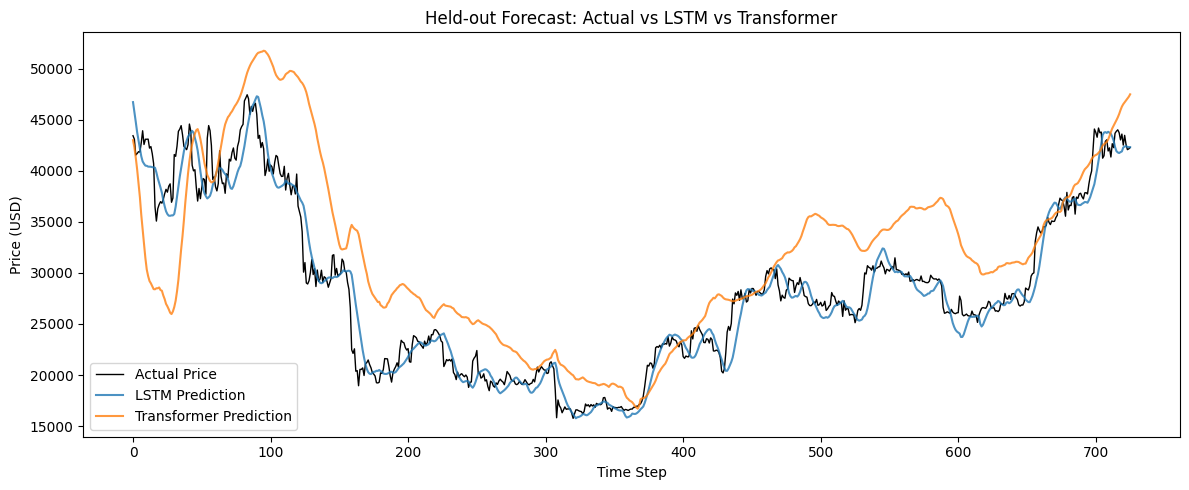

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(actual,       label="Actual Price", color="black", lw=1)
plt.plot(pred_lstm,    label="LSTM Prediction",      alpha=0.8)
plt.plot(pred_tr,      label="Transformer Prediction",alpha=0.8)
plt.title("Held-out Forecast: Actual vs LSTM vs Transformer")
plt.xlabel("Time Step"); plt.ylabel("Price (USD)")
plt.legend(); plt.tight_layout(); plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Lengths: 726 726 726 726


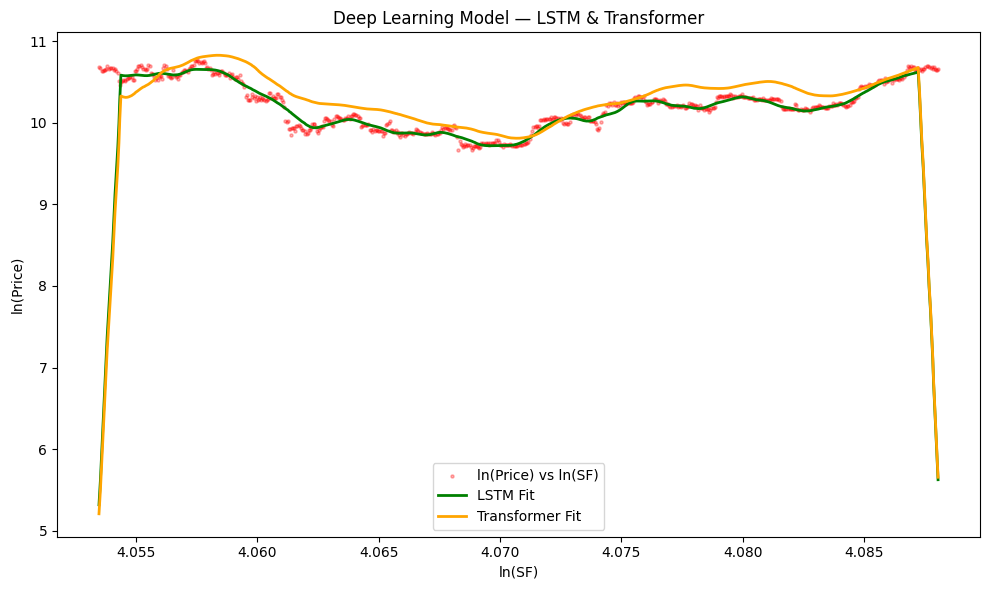

In [ ]:
# number of held-out predictions
n_test = len(y_test)

# take sf_ratio for the last n_test days
sf_tail = df["sf_ratio"].values[-n_test:]
lnSF     = np.log(sf_tail)

# true prices and predictions
actual_usd = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()
lnP_true   = np.log(actual_usd)

lstm_usd = scaler_y.inverse_transform(
    model_lstm.predict(X_test).reshape(-1,1)
).flatten()
lnP_lstm = np.log(lstm_usd)

tr_usd = scaler_y.inverse_transform(
    model_tr.predict(X_test).reshape(-1,1)
).flatten()
lnP_tr   = np.log(tr_usd)

# sanity check
print("Lengths:", len(lnSF), len(lnP_true), len(lnP_lstm), len(lnP_tr))

# sort by lnSF and compute rolling fits
order      = np.argsort(lnSF)
sf_sorted  = lnSF[order]
lstm_sorted = lnP_lstm[order]
tr_sorted   = lnP_tr[order]

window = max(5, n_test//20)  # e.g. 5% of points, at least 5
lstm_smooth = np.convolve(lstm_sorted, np.ones(window)/window, mode="same")
tr_smooth   = np.convolve(tr_sorted,   np.ones(window)/window, mode="same")

plt.figure(figsize=(10,6))
plt.scatter(lnSF, lnP_true, c="red", s=5, alpha=0.3, label="ln(Price) vs ln(SF)")
plt.plot(sf_sorted, lstm_smooth, color="green",  lw=2, label="LSTM Fit")
plt.plot(sf_sorted, tr_smooth,   color="orange", lw=2, label="Transformer Fit")

plt.title("Deep Learning Model — LSTM & Transformer")
plt.xlabel("ln(SF)")
plt.ylabel("ln(Price)")
plt.legend()
plt.tight_layout()
plt.show()
